In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/Birds-Dataset" -r "/content"

## Library Import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten , Dropout , Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
#sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix , classification_report

## Display images

In [2]:
def show_image_samples(gen):
    class_dict=gen.class_indices
    class_names=list( class_dict.keys())      # get the names of birds 
    images,labels=next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1) # add images to subplots
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=class_names[index]
        plt.title(class_name, color='blue', fontsize=16)  # show the bird type as the title
        plt.axis('off')
    plt.show()

## Plot training & validation statistics

In [3]:
def tr_plot(tr_data, start_epoch):
    #  get the train and validation loss , accuracy from history object
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]

    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)  

    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    # indentify the best result epoch 
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    # plot training and validation loss
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')  # plot title
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    # plot training and validation accuracy results
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

## Data Generators for train and validation

In [4]:
# define input image shape (224,224,3)
height=224
width=224
channels=3
batch_size= 32 
img_shape=(height, width, channels)
img_size=(height, width)

# define the train and validation data directories
train_dir = "Birds-Dataset/Train"
valid_dir = "Birds-Dataset/Validation"

# scaler function used to normalize the input images
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

# define the datagenerator with some augmentations
train_gen=ImageDataGenerator(preprocessing_function=scalar , 
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

# define the validation datagenerator only with noramlization
valid_gen=ImageDataGenerator(preprocessing_function=scalar)

# define data gen objects to retrive data from the train and validation directories
train_gen= train_gen.flow_from_directory( train_dir , target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen= valid_gen.flow_from_directory( valid_dir , target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)


train_steps =int(len(train_gen.labels)/batch_size)
valid_steps = int( len( valid_gen.labels )/batch_size )

Found 1160 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


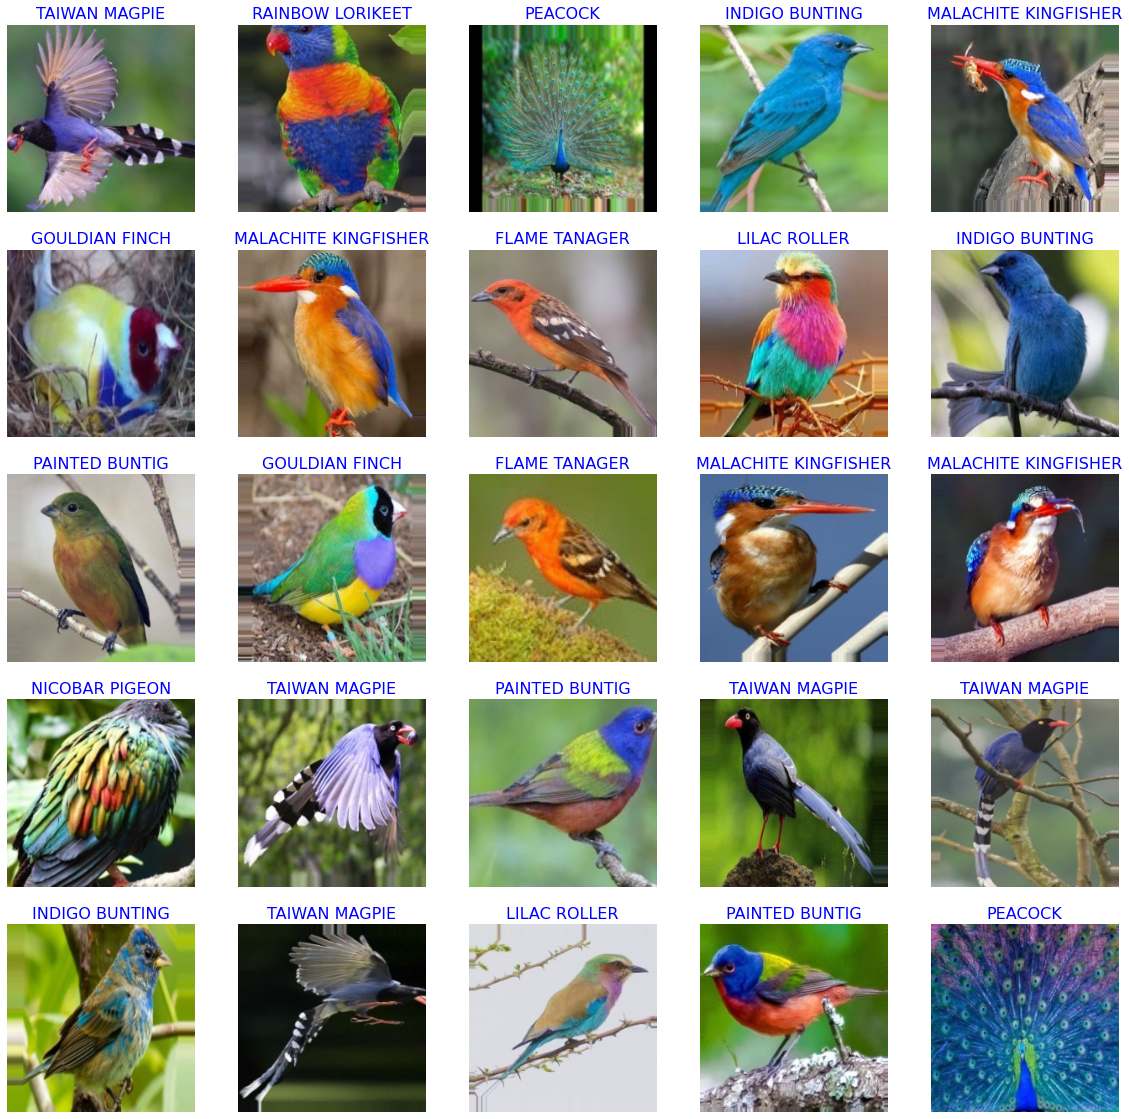

In [9]:
show_image_samples(train_gen)

## Define the convolution keras model

In [5]:
"""
define a convolution block with 
  1. conv layer
  2. batchnormalization
  3. activation (relu)
  4 . conv layer
  5. batchnormalization
  6. activation
  7. maxpool layer
"""
def conv_block( input , num_kernels , kernel_size , kernel_initializer = 'he_uniform' , padding='same' , dropout=False):
  x = input
  x = Conv2D( num_kernels , ( kernel_size ,kernel_size) ,kernel_initializer= kernel_initializer , padding= padding )(x)
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Activation('relu')(x)
  x = Conv2D( num_kernels , ( kernel_size ,kernel_size) ,kernel_initializer= kernel_initializer , padding= padding )(x)
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(2,2)(x)

  if(dropout):
    x = Dropout( 0.2 )(x)

  return x

In [6]:
# define the model using funtional API

# Define model input layers.
input = Input( shape=( img_shape ), )
# define conv_block 1
x = conv_block( input , num_kernels= 64 , kernel_size= 3  )

# define conv_block2
x = conv_block( x , num_kernels= 128 , kernel_size= 3 )

# define conv_block3
x = conv_block( x  , num_kernels=256 , kernel_size=3 )

# define conv_block3
x = conv_block( x  , num_kernels=256 , kernel_size=3 , dropout=True)

# define thre linear classification header
x = Flatten()(x)
 
# 512 neuron hidden layer
x = Dense(1024, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001) , name="dense_1" )(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dropout( 0.3 )(x)
x = Dense( 256  , activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001) , name="dense_2" )(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dropout( 0.4 )(x)
# final classification layer
output = tf.keras.layers.Dense( train_gen.num_classes , activation='softmax')(x)

model = Model(inputs=[ input ] , outputs=[ output ])
# define the optimization method
optimizer = tf.keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1)

# compile the model with categorical crossentropy loss and Adamax optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0     

## Model training ( use learning rate decay method )

In [8]:
import math

epochs =30  # number of training epochs
initial_learning_rate = 0.001   # starting learning rate

# define a learning rate decau function
def lr_step_decay(epoch, lr):
    drop_rate = 0.8
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# define a checkpoint for save the best model while training based on validation losss
save_checkpoint = ModelCheckpoint('CNN_bird_classification.h5', verbose=1, save_best_only=True)

callbacks=[LearningRateScheduler(lr_step_decay, verbose=1) , save_checkpoint ]

# train the model
history=model.fit( x=train_gen,  epochs=epochs, verbose=1 , callbacks =  callbacks ,  validation_data=valid_gen,
                  shuffle=False,  initial_epoch=0 )

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
37/37 [==============================] - 48s 873ms/step - loss: 4.4730 - accuracy: 0.4310 - val_loss: 6.9519 - val_accuracy: 0.2750

Epoch 00001: val_loss improved from inf to 6.95187, saving model to CNN_bird_classification.h5
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
37/37 [==============================] - 30s 786ms/step - loss: 3.4303 - accuracy: 0.7198 - val_loss: 3.9927 - val_accuracy: 0.5500

Epoch 00002: val_loss improved from 6.95187 to 3.99265, saving model to CNN_bird_classification.h5
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
37/37 [==============================] - 29s 784ms/step - loss: 3.1815 - accuracy: 0.8034 - val_loss: 3.5156 - val_accuracy: 0.7100

Epoch 00003: val_loss improved from 3.99265 to 3.51556, saving model to CNN_bird_classification.h5
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to

## Plot traning and validation loss & accuracy

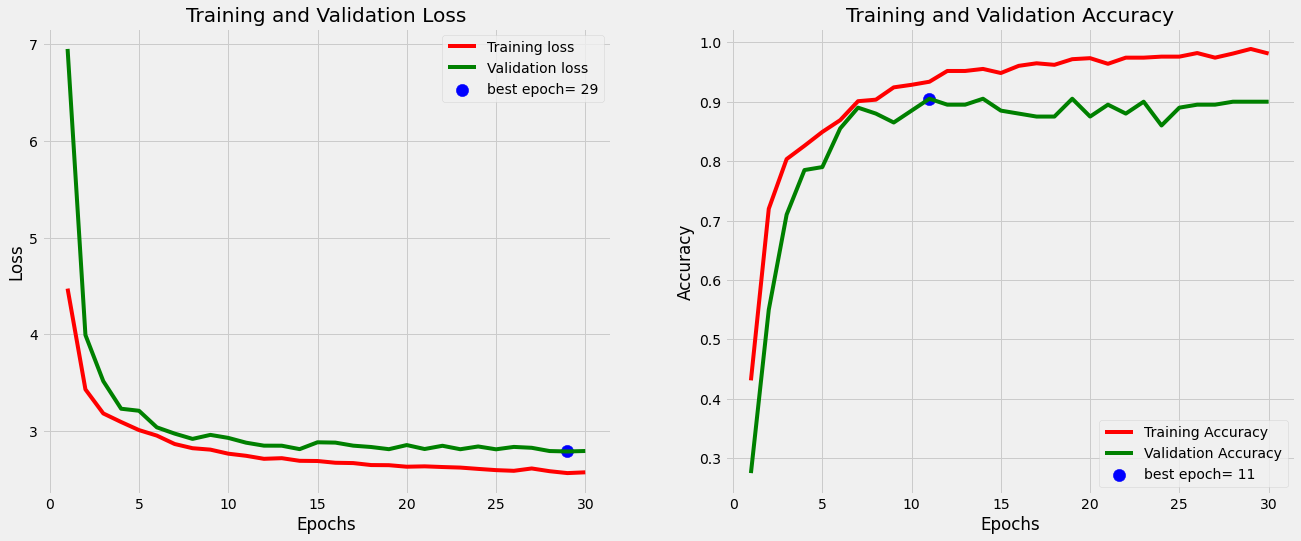

6/6 [==============================] - 2s 233ms/step - loss: 2.8042 - accuracy: 0.8958


In [9]:
tr_plot(history, 0)
acc=model.evaluate( valid_gen,batch_size=32, steps=valid_steps, verbose=1)[1]*100

## confusion matrix and classification report

In [10]:
def print_info( test_gen, preds  ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 

    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}

    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
 
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred

            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            
        y_pred.append(pred_index)    
  
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

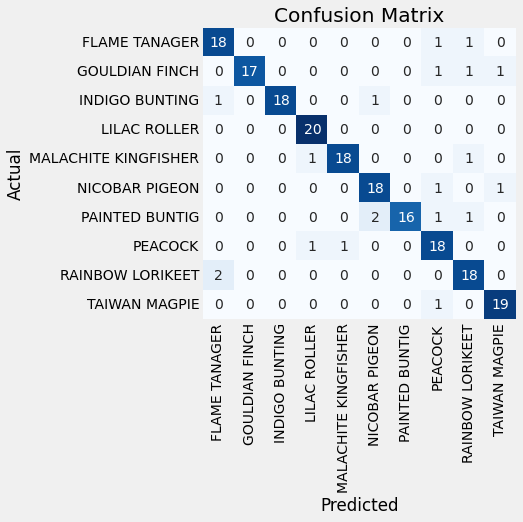

Classification Report:
----------------------
                       precision    recall  f1-score   support

       FLAME TANAGER       0.86      0.90      0.88        20
      GOULDIAN FINCH       1.00      0.85      0.92        20
      INDIGO BUNTING       1.00      0.90      0.95        20
        LILAC ROLLER       0.91      1.00      0.95        20
MALACHITE KINGFISHER       0.95      0.90      0.92        20
      NICOBAR PIGEON       0.86      0.90      0.88        20
      PAINTED BUNTIG       1.00      0.80      0.89        20
             PEACOCK       0.78      0.90      0.84        20
    RAINBOW LORIKEET       0.82      0.90      0.86        20
       TAIWAN MAGPIE       0.90      0.95      0.93        20

            accuracy                           0.90       200
           macro avg       0.91      0.90      0.90       200
        weighted avg       0.91      0.90      0.90       200



In [11]:
print_code=0
preds=model.predict(valid_gen) 
print_info( valid_gen, preds)  

## 3D visualization of data distribution 

In [12]:
# define the bird names dictionary
class_indices = train_gen.class_indices

class_dict ={}
for key , value in class_indices.items():
  class_dict[value] = key

In [13]:
# get the individual tensors using the train data generator for TSNE representations
train_x_set , train_y_set = [] , []
for idx , (i_x , i_y) in enumerate(train_gen):
  train_x_set.append( i_x )
  train_y_set.append( i_y )

  if( idx == train_steps ):
    break

train_x_set , train_y_set = np.array( train_x_set ) , np.array(train_y_set)
x_bird = np.concatenate( [  i_tensor  for i_tensor in train_x_set ] , axis=0 )
y_bird = np.concatenate( [ np.argmax(i_tensor , axis=-1 ) for i_tensor in train_y_set ] , axis=0 )
y_birdnames = [  class_dict[i_bird] for i_bird in y_bird ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [14]:
from keras import backend as K

# define Sequential model to get the final dense layer feature vector out 
get_2nd_dense_output = K.function( [model.layers[0].input],
                                  [ model.get_layer("dense_2").output])

dense_vector = []
for i_x in x_bird :
  # forward pass each image and get the feature vector from intermediate dense layer 
  dense2_output = get_2nd_dense_output([ i_x[np.newaxis,:,:,:] ])
  # append the results into list
  dense_vector.append( dense2_output[0] )

# define the tsne vector
tsne_vec = np.concatenate( [  i_vec  for i_vec in dense_vector ] , axis=0 )

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

In [16]:
# train the tsne model with the input image featues obtained from previous cell
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform( tsne_vec )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.023s...
[t-SNE] Computed neighbors for 1160 samples in 0.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 4.220933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.960461
[t-SNE] KL divergence after 300 iterations: 0.755871


In [17]:
import pandas as pd
df_birds = pd.DataFrame()
# define a dataframe for make the work easy
df_birds['tsne-3d-one'] = tsne_results[:,0]
df_birds['tsne-3d-two'] = tsne_results[:,1]
df_birds['tsne-3d-three'] = tsne_results[:,2]
df_birds['y'] = y_birdnames

## 3d  plot with the bird data representations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


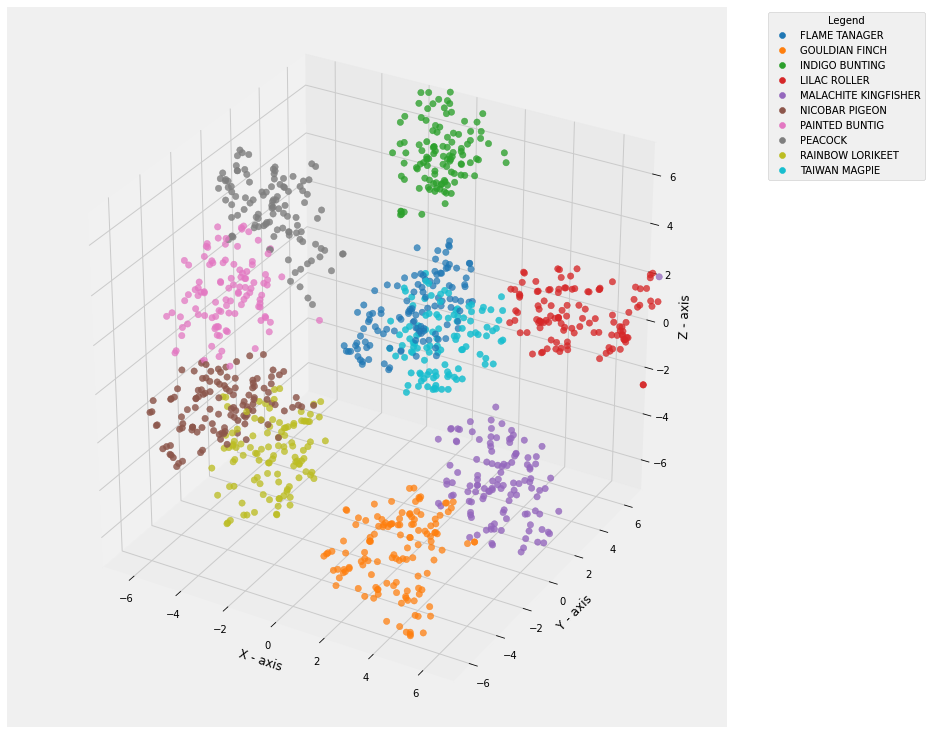

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
fig.add_axes(ax)

sc= ax.scatter(
    xs=df_birds["tsne-3d-one"], 
    ys=df_birds["tsne-3d-two"], 
    zs=df_birds["tsne-3d-three"], 
    s=40 ,
    c= y_bird , 
    cmap='tab10'
)

# produce a legend with the unique colors from the scatter
legend = ax.legend(handles=sc.legend_elements()[0], title="Legend",  bbox_to_anchor=(1.05, 1), loc=2 , labels= list( class_indices.keys() )  )
ax.add_artist(legend)

ax.set_xlabel('X - axis')
ax.set_ylabel('Y - axis')
ax.set_zlabel('Z - axis')
ax.set_xlim( -7,7 )
ax.set_ylim( -7,7 )
ax.set_zlim( -7,7 )
plt.show()